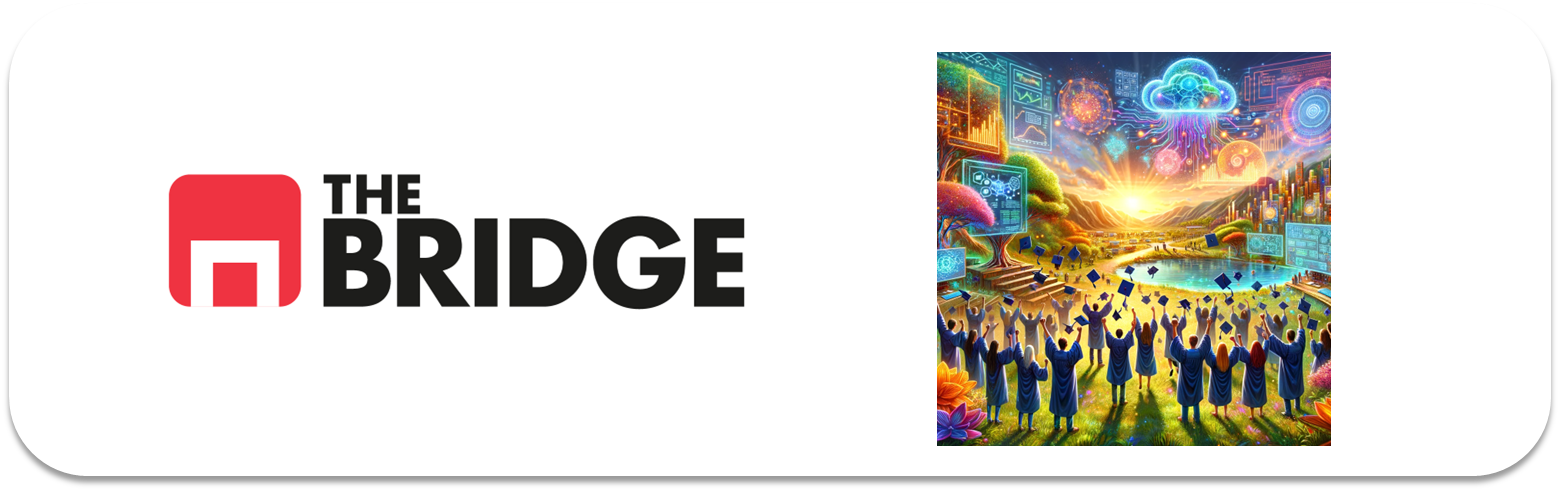

# Masterclass: Pipelines de Sklearn (I)

Los Pipelines son un tipo de objeto compuesto de Sklearn que facilitan mucho el trabajo repetitivo de procesado y entrenamiento. Se construyen como una secuencia de "transformadores" (modelos, preprocesadores, etc) que se aplican uno detrás de otro y a los que se pueden añadir selección por columnas y funciones diseñadas por el usuario.

In [1]:
def data_report(df):
    '''Esta funcion describe los campos de un dataframe de pandas de forma bastante clara, crack'''
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)

    return concatenado.T

## Datos de Partida  
Sí, my heart will go on

In [2]:
# pip install joblib

In [3]:
import joblib
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score


En esta ocasión tenemos test y train separados. Vamos a suponer que test son datos nuevos y sólo los cargaremos al final para ver la potencia del pipeline.

In [4]:
train = pd.read_csv("./data/titanic_train.csv")


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data_report(train)

COL_N,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
DATA_TYPE,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.0,77.1,0.22
UNIQUE_VALUES,891,2,3,891,2,88,7,7,681,248,147,3
CARDIN (%),100.0,0.22,0.34,100.0,0.22,9.88,0.79,0.79,76.43,27.83,16.5,0.34


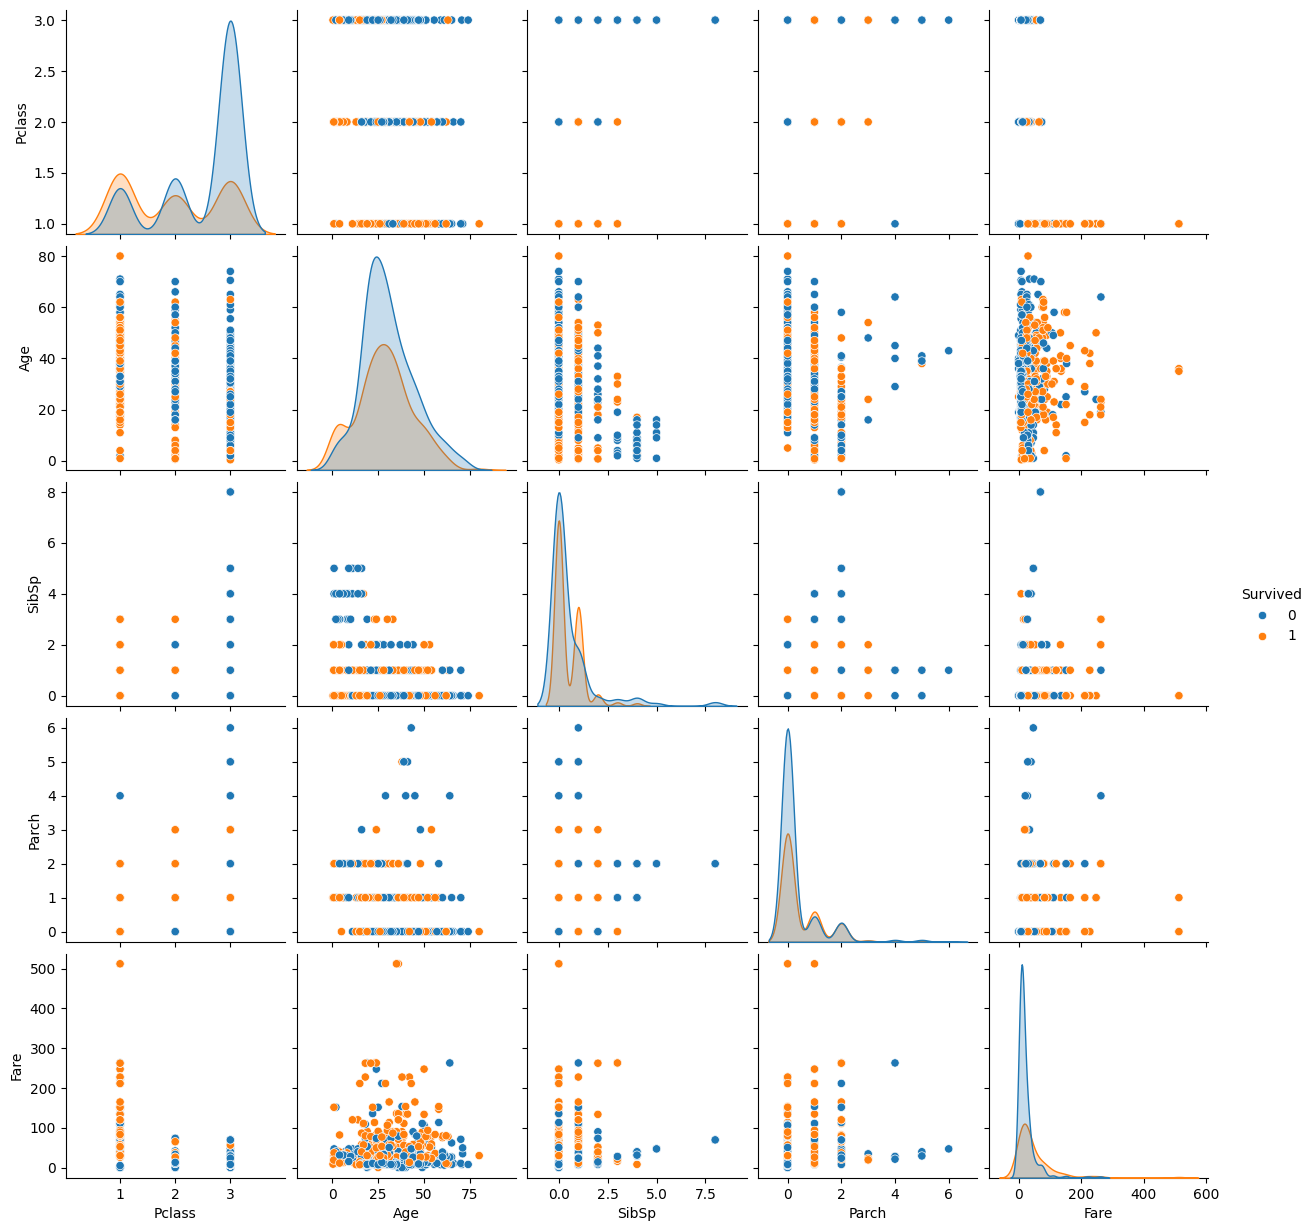

In [8]:
sns.pairplot(train.drop(["Name","PassengerId"],axis = 1), hue = "Survived")

## LIMPIEZA INICIAL  


Nos apuntamos las columnas que son identificadores unicos para descartarlos posteriormente

In [9]:
columns_to_exclude = ["PassengerId", "Name"]

Tenemos que tomar una decisión respecto a cuatro features, debido a su nivel de "nulos", o su cardinaliad siendo "textual"/"categórica": __Age, Cabin, Ticket, Embarked__ .  
__Fare__ podría ser discutible por su cardinalidad (27.83) pero es numérica, sin missings, nos las quedamos.

### Age

Esta suficientemente informada?

In [10]:
print(len(train[train.Age.isna() == False])/len(train))

0.8013468013468014


Un 80% tiene buena pinta si la variables es continua o categorica como para hacer una imputación.  
Como es continua pero entera (no hay decimales) podemos imputarle la media redondeada, la mediana, o incluso convertirla a categorica con tramos iguales (binning) y escoger la moda de esos binnings.   
Para este ejemplo le imputaremos la **mediana**.  

Pero no lo hacemos ya, esperamos a tener toda la estrategia de imputación/drop clara... O hazlo ya impaciente, si eres de los que le gusta ir para arriba y para abajo :-)

### Embarked

Esta casi completamente informada, así que la quiero conservar.  
Tenemos que decidir qué hacemos con los dos valores faltantes:
- Puedo hacer una imputación a la categoría más frecuente
- Puedo "prescindir" de las filas en las que falta esta feature (ojo tendré que hacerlo luego posteriormente con cada instancia que me viniera sin este dato, por eso no suele ser aconsejable este método si queremos dar una "etiqueta"/Prediccion/f(x) para todas las instancias que nos lleguen en el futuro)
- Puedo prescindir de la columna

Faltando tan pocos valores lo más práctico es imputar, pero si fueran valores más altos (más de un 20%, pero la experiencia ya os dirá el número para el campo de dominio que trabajéis), es bueno ver si es fácil imputar y si es informativa la feature

In [11]:
train.Embarked.value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

Solo tres clases, imputariamos además S a los valores faltantes (la más frecuente)

¿Es informativa? Lo mejor es hacer un test estadístico contra el target o calcular su information value. Ahora lo vamos a hacer a "ojimetro"

In [12]:
train[train.Embarked == "S"].Survived.value_counts(True)

Survived
0    0.663043
1    0.336957
Name: proportion, dtype: float64

In [13]:
train[train.Embarked == "C"].Survived.value_counts(True)

Survived
1    0.553571
0    0.446429
Name: proportion, dtype: float64

In [14]:
train[train.Embarked == "Q"].Survived.value_counts(True)

Survived
0    0.61039
1    0.38961
Name: proportion, dtype: float64

In [15]:
train.Survived.value_counts(True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Ser S o Q no parece diferenciarse mucho del conjunto total, pero haber embarcado en C, sí que cambia algo la distribución. Así que me la quedo e imputo la de mayor frecuencia

### Cabin

En Cabin tenemos el problema de que faltan muchos valores, tenemos un 23% escaso de instancias informadas

In [16]:
print(len(train[train.Cabin.isna() == False])/len(train))

0.22895622895622897


Las features a imputar tienen que tener valor informativo (correlar con el target) y además un método "sencillo" para poder hacer esa imputación

Antes de comprobar el valor informativo, veamos la cardinaliad (valores diferentes que tiene sobre el total) en el caso de categóricas o la varianza/distribución en el caso de numéricas

Cabin es categórca/textual, veamos cuantos registros diferentes en relación con el total de informados

In [17]:
print(len(train.Cabin.unique())/len(train[train.Cabin.isna() == False]))


0.7254901960784313


El 72% de los valores informados son únicos, lo que es normal porque son camarotes, hacer una imputación es practicamente imposible, así que prescindiremos de la columna

In [18]:
columns_to_exclude.append("Cabin")
print(columns_to_exclude)

['PassengerId', 'Name', 'Cabin']


### Ticket

Mucha cardinalidad (76%) y texto (object), veamos que pinta tiene

In [19]:
train.Ticket.value_counts(True)

Ticket
347082      0.007856
CA. 2343    0.007856
1601        0.007856
3101295     0.006734
CA 2144     0.006734
              ...   
9234        0.001122
19988       0.001122
2693        0.001122
PC 17612    0.001122
370376      0.001122
Name: proportion, Length: 681, dtype: float64

De primeras, fuera. Si tuviera que rascar a lo mejor intentaríamos buscar alguna "codificación" de cada Ticket (por ejemplo relacionandolo con Fare, se ve que los hay letraletra numero y solo número), pero eso si necesito rascar más

In [20]:
columns_to_exclude.append("Ticket")
print(columns_to_exclude)

['PassengerId', 'Name', 'Cabin', 'Ticket']


In [21]:
[col for col in train.columns if col not in columns_to_exclude]

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

### Levad anclas, soltad amarres,...

## Funciones vs Pipeline

A partir de aquí vamos a hacer dos hilos de preprocesado que harán lo mismo, uno con funciones y otro con Pipeline, pero antes un poco de teoría.

## PIPELINES

### Terminología sklearn:

#### Transformer

Un **transformer** es un tipo de objeto que implementa los métodos `fit()` y `transform()`. Se utiliza para transformar los datos de entrada (por ejemplo, normalizarlos o extraer características) antes de alimentar estos datos a un modelo de machine learning. El método `fit()` aprende los parámetros necesarios para la transformación a partir de los datos de entrada, y el método `transform()` aplica esta transformación.

- **Ejemplo**: `StandardScaler` es un transformer que normaliza las características eliminando la media y escalando a varianza unitaria.

#### Estimator

Un **estimator** es cualquier objeto que puede estimar algunos parámetros basados en un conjunto de datos. En el contexto de Scikit-learn, se refiere principalmente a los objetos de machine learning que pueden aprender de los datos. Esto significa que todo estimator implementa el método `fit()`, que es responsable de aprender los parámetros del modelo a partir de los datos de entrenamiento.

- **Ejemplo**: `RandomForestClassifier` es un estimator que aprende a clasificar los datos en categorías basándose en las características de entrada.

#### Predictor

Un **predictor** es un tipo de estimator que, después de ser entrenado sobre los datos (es decir, después de que el método `fit()` se ha aplicado), puede hacer predicciones sobre nuevos conjuntos de datos utilizando el método `predict()`. En muchos casos, los objetos que son predictores también implementan el método `score()` para evaluar la calidad de las predicciones.

- **Ejemplo**: `LinearRegression` es tanto un estimator como un predictor. Aprende (o estima) los parámetros de un modelo lineal para describir la relación entre las variables independientes y la variable dependiente durante la fase de entrenamiento, y luego puede predecir los valores de la variable dependiente para nuevos datos de entrada.

En resumen, en Scikit-learn:
- **Transformers** transforman los datos.
- **Estimators** aprenden de los datos.
- **Predictors** hacen predicciones basadas en los datos aprendidos.

Estos conceptos son parte del diseño de Scikit-learn, que promueve la reutilización, la modularidad y la composición de los algoritmos de machine learning.


### Pipelines:

Un pipeline es una lista de objetos (llamados "transformers" en terminología Sklearn, no confundir con los transformers de Deep Learning) que se van a ejecutar en orden cada vez que llamemos a su método fit o fit_transform o predict. Por ejemplo, si hemos creado un objeto Pipeline con nombre PipeExample, luego podremos ejecutar PipeExample.fit -> (que llama a los métodos fit_transform de todos los elementos de PipeExample, salvo del último que sólo ejecuta fit) o PipeExample.predict -> (Que llama a los métodos transform de todos los elementos de PipeExample, salvo del último que sólo ejecutara predict) o PipeExample.fit_transform (Que llamará a todos los fit_transform de todos los elementos). Evidentemente el último elemento de PipeExample tiene que tener un método predict o un método fit o un método fit_transform para poder ejecutar los comandos anteriores.

La principal ventaja de utilizar un pipeline es que combina múltiples etapas de preprocesamiento y modelado en un único bloque, lo que facilita el proceso de validación cruzada y otras técnicas de evaluación de modelos sin violar los principios de separación de datos de entrenamiento y prueba. Además, mejora la reproducibilidad y la claridad del código de machine learning.



#### Ejemplos:

```python
PipeExample = Pipeline(["a",(Transformer_A()),("b",(Transformer_B()),("c",(Transformer_C())])
```

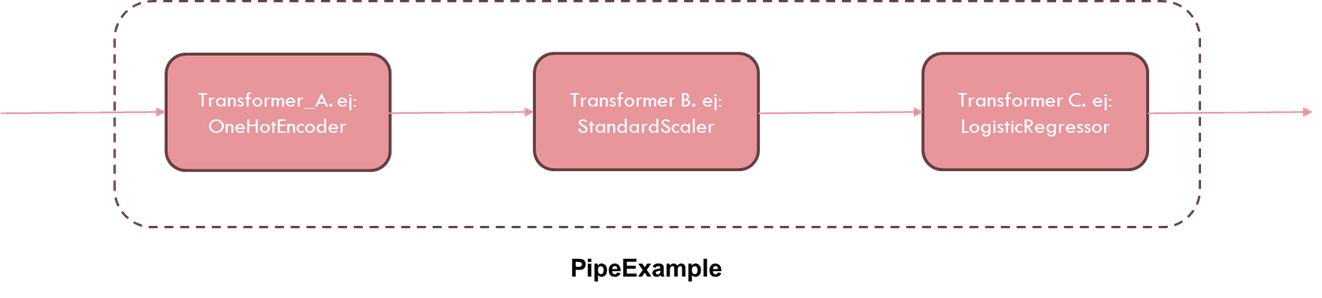


$$*$$

Si sobre el pipeline anterior ejecutamos el método `fit`:

```python
PipeExample.fit(X<,y>) # <,y> quiere decir que puede ser un fit a solo X (como un StandardScaler o una PCA)o a X,y (como en un LogisticRegressor u otros modelos supervisados)
```



* Equivale a Transformer_C.fit(Transformer_B.fit_transform(Transformer_A.fit_transform(X<,y>)<,y>)<,y>):

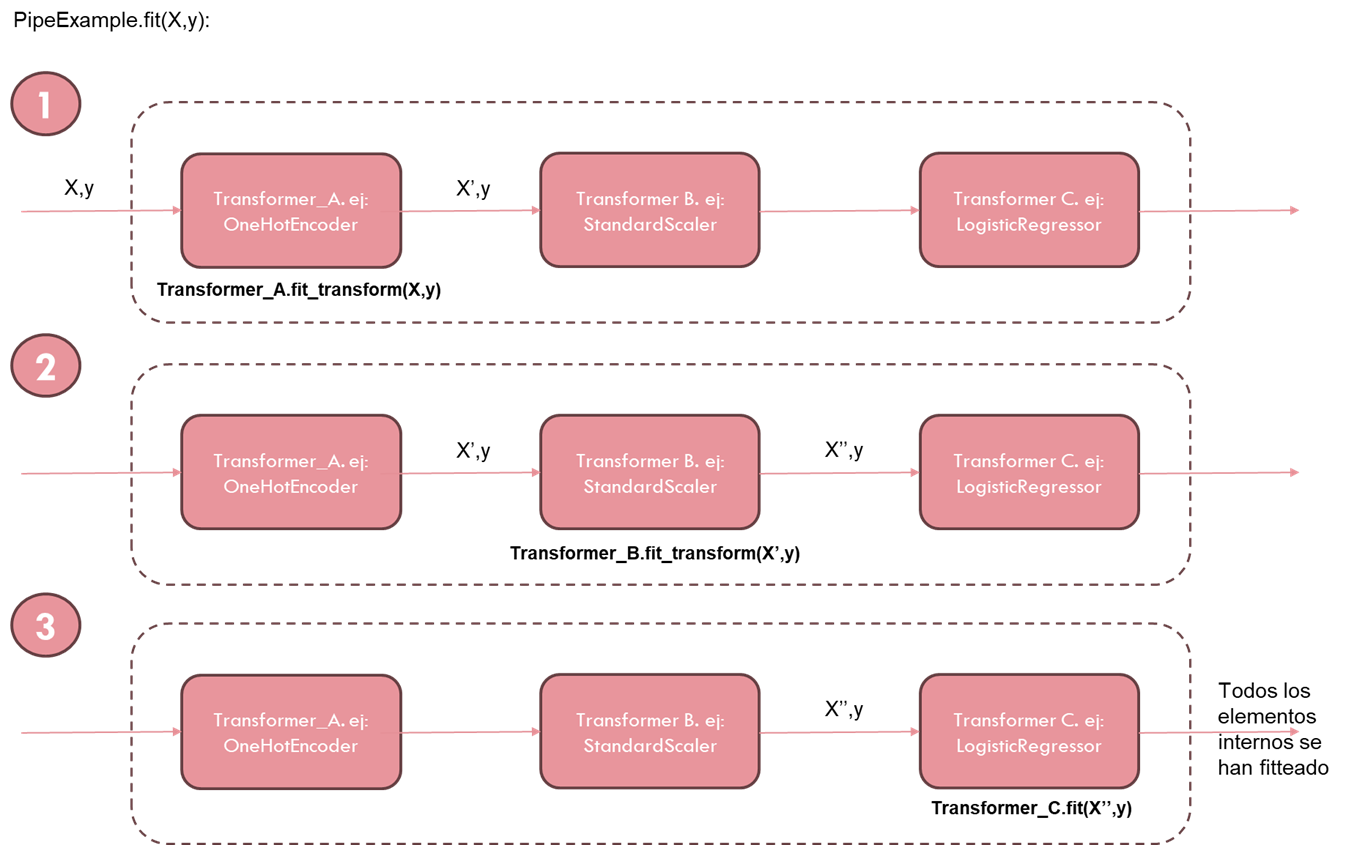



$$*$$

Si sobre el pipeline anterior ejecutamos el método `predict` (lo que implica que el último elemento del pipeline debe tener un método `predict`):

```python
PipeExample.predict(X)
```



* PipeExample.predict(X) equivale a Transformer_C.predict(Transformer_B.transform(Transformer_A.transform(X)))  

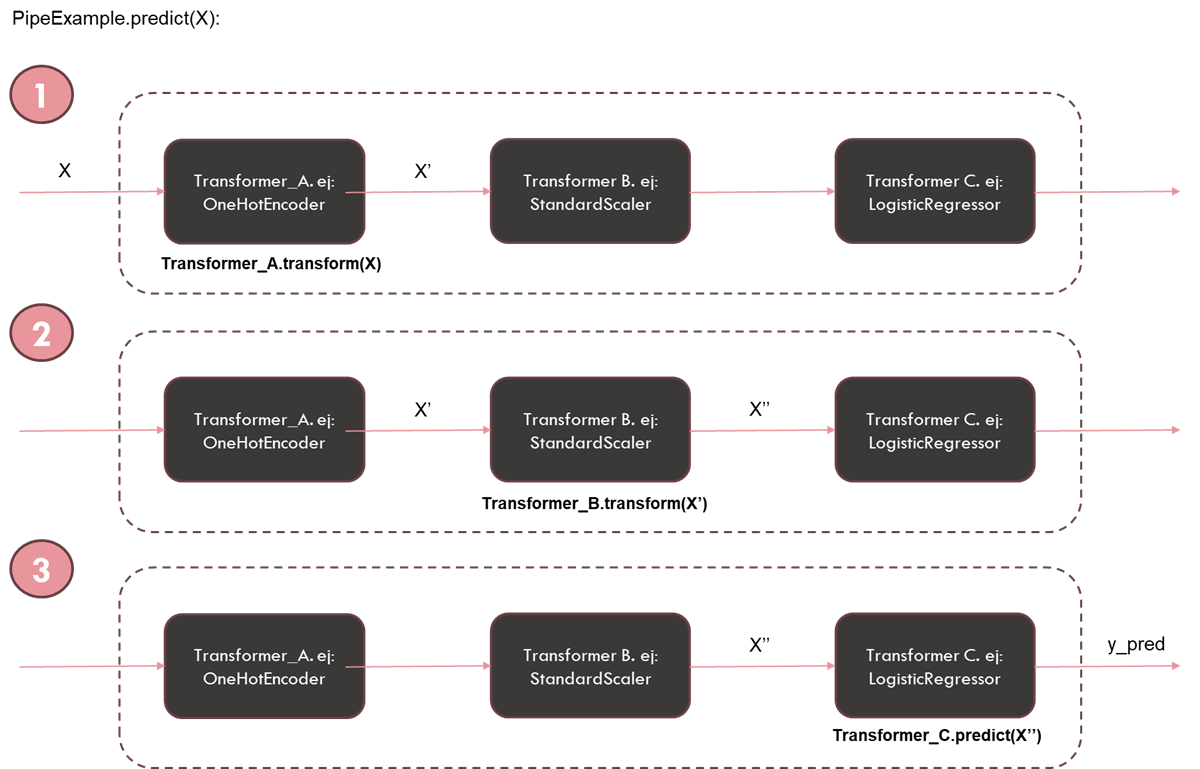


Además:

Como un Pipeline es un transformer :-) se puede meter como paso dentro de otro Pipeline (lo cual para entenderlo lo complica, pero le da mucha versatilidad) (OJO si ese pipeline termina con un "modelo" que no tiene fit_transform, tiene que ser el último elemento del nuevo pipeline o dará error)

Supongamos que Transformer_C es un modelo ( ejemplo Transformer_C es RandomForestClassifier):
* PipePipeExample = Pipeline([("mal_ejemplo",PipeExample()), ("da_igual", OtroPipe())]) -> Dará error  


* PiPeGoodExample = Pipeline([ ("el_primero", OtroPipe()),("bien",PipeExample())]) -> Si OtroPipe no es un modelo o tiene fit_transform, todo OK :-)  



## Exclusión de columnas

In [22]:
columns_to_exclude

['PassengerId', 'Name', 'Cabin', 'Ticket']

In [23]:
# FUNCTION_BASED_PREPROCESSING

def func_exclude_columns(X, exclude_cols = columns_to_exclude):
    # Skip missing values from colum
    X_temp = X[[col for col in X.columns if col not in exclude_cols]].copy()
    return X_temp

### Construyendo Pipelines

In [24]:
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer

In [25]:
columns_to_exclude

['PassengerId', 'Name', 'Cabin', 'Ticket']

In [26]:
# Column Transformer nos permite aplicar diferentes transformers según las columnas

pipe_exclude_columns = ColumnTransformer([
    ("etapa_de_exclusión", "drop", columns_to_exclude)
    ], 
    remainder = "passthrough")


In [24]:
# Probemos que los dos dan "el mismo resultado"

In [27]:
train_compacto = func_exclude_columns(train, columns_to_exclude)
train_compacto

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [28]:
pipe_exclude_columns

ColumnTransformer(remainder='passthrough',
                  transformers=[('etapa_de_exclusión', 'drop',
                                 ['PassengerId', 'Name', 'Cabin', 'Ticket'])])

In [29]:
pipe_train_compacto = pipe_exclude_columns.fit_transform(train)
pipe_train_compacto

array([[0, 3, 'male', ..., 0, 7.25, 'S'],
       [1, 1, 'female', ..., 0, 71.2833, 'C'],
       [1, 3, 'female', ..., 0, 7.925, 'S'],
       ...,
       [0, 3, 'female', ..., 2, 23.45, 'S'],
       [1, 1, 'male', ..., 0, 30.0, 'C'],
       [0, 3, 'male', ..., 0, 7.75, 'Q']], dtype=object)

In [30]:
pipe_exclude_columns.get_feature_names_out()

array(['remainder__Survived', 'remainder__Pclass', 'remainder__Sex',
       'remainder__Age', 'remainder__SibSp', 'remainder__Parch',
       'remainder__Fare', 'remainder__Embarked'], dtype=object)

In [31]:
df_check = pd.DataFrame(pipe_train_compacto, columns = pipe_exclude_columns.get_feature_names_out())
df_check

,remainder__Survived,remainder__Pclass,remainder__Sex,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare,remainder__Embarked
0,0,3,male,22.0,1,0,7.25,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.925,S
3,1,1,female,35.0,1,0,53.1,S
4,0,3,male,35.0,0,0,8.05,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0,S
887,1,1,female,19.0,0,0,30.0,S
888,0,3,female,NaN,1,2,23.45,S
889,1,1,male,26.0,0,0,30.0,C


Primera ventaja para las funciones, devuelven el dataframe, segunda ventaja, el paso de parámetros es más flexible

## Imputamos valores faltantes

In [32]:
age_median = int(train_compacto.Age.median())
age_median

28

In [33]:
train_compacto.Embarked.mode()[0]

'S'

In [34]:
# FUNCTION BASED PROCESSING
def func_missing_imputer(X, median_col_imputed = [], mode_col_imputed = []):
    X_temp = X.copy()
    
    for col in median_col_imputed:
        valor_imputado = round(X_temp[col].median(),0)
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado

    for col in mode_col_imputed:
        valor_imputado = X_temp[col].mode().values[0]
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
        
    return X_temp
        

In [35]:
# Si el interprete no nos ayuda con la lectura de los docstrings, podemos usar ??
ColumnTransformer??

Init signature:
ColumnTransformer(
    transformers,
    *,
    remainder='drop',
    sparse_threshold=0.3,
    n_jobs=None,
    transformer_weights=None,
    verbose=False,
    verbose_feature_names_out=True,
    force_int_remainder_cols=True,
)
Source:        
class ColumnTransformer(TransformerMixin, _BaseComposition):
    """Applies transformers to columns of an array or pandas DataFrame.

    This estimator allows different columns or column subsets of the input
    to be transformed separately and the features generated by each transformer
    will be concatenated to form a single feature space.
    This is useful for heterogeneous or columnar data, to combine several
    feature extraction mechanisms or transformations into a single transformer.

    Read more in the :ref:`User Guide <column_transformer>`.

    .. versionadded:: 0.20

    Parameters
    ----------
    transformers : list of tuples
        List of (name, transformer, columns) tuples specifying the
        transfo

In [36]:
# PIPELINE PROCESSING
from sklearn.impute import SimpleImputer

# Vamos a hacer un pequeño truco :-), que luego repetiremos porque después del primer paso ya no podemos utilizar las columnas de pandas
imputer_step = ColumnTransformer(
    [
        ("Impute_Numeric", SimpleImputer(strategy = "median"), ["Age"]),
        ("Impute_Mode", SimpleImputer(strategy = "most_frequent"), ["Embarked"]),
        # ("Impute_Unknown", SimpleImputer(strategy = "constant", fill_value= "UNK"), ["Lista_de_columnas"]),
        ("Exclude", "drop", columns_to_exclude)
    ], 
    remainder = "passthrough",
    verbose_feature_names_out = False
    )

pipe_missings = Pipeline([("first_stage", imputer_step)])



In [37]:
train_almost_ready = func_missing_imputer(train_compacto, median_col_imputed= ["Age"], mode_col_imputed= ["Embarked"])
train_almost_ready

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,28.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [36]:
train_almost_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [38]:
pipe_train = pipe_missings.fit_transform(train)
pipe_train

array([[22.0, 'S', 0, ..., 1, 0, 7.25],
       [38.0, 'C', 1, ..., 1, 0, 71.2833],
       [26.0, 'S', 1, ..., 0, 0, 7.925],
       ...,
       [28.0, 'S', 0, ..., 1, 2, 23.45],
       [26.0, 'C', 1, ..., 0, 0, 30.0],
       [32.0, 'Q', 0, ..., 0, 0, 7.75]], dtype=object)

In [40]:
df_check = pd.DataFrame(pipe_train, columns = pipe_missings.get_feature_names_out())
df_check

,Age,Embarked,Survived,Pclass,Sex,SibSp,Parch,Fare
0,22.0,S,0,3,male,1,0,7.25
1,38.0,C,1,1,female,1,0,71.2833
2,26.0,S,1,3,female,0,0,7.925
3,35.0,S,1,1,female,1,0,53.1
4,35.0,S,0,3,male,0,0,8.05
...,...,...,...,...,...,...,...,...
886,27.0,S,0,2,male,0,0,13.0
887,19.0,S,1,1,female,0,0,30.0
888,28.0,S,0,3,female,1,2,23.45
889,26.0,C,1,1,male,0,0,30.0


In [41]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       891 non-null    object
 1   Embarked  891 non-null    object
 2   Survived  891 non-null    object
 3   Pclass    891 non-null    object
 4   Sex       891 non-null    object
 5   SibSp     891 non-null    object
 6   Parch     891 non-null    object
 7   Fare      891 non-null    object
dtypes: object(8)
memory usage: 55.8+ KB


## Codificación de Variables Categóricas (OneHotEnconder vs OrdinalEncoder)

El LabelEncoder se recomienda solo para target

Tenemos dos features a codificar: __Sex__ y __Embarked__  
Ambas tienen pocos valores, por lo que podemos usar un OneHotEncoder, si tuvieran muchos valores de etiquetas podríamos hacer un OneHotEncoder y una PCA sobre estos, o agrupar las categorías en función de su correlación con el target, o buscar algún mecanismo de agrupación no supervisado que las agrupe por semejanza

In [42]:
# Opción 1 Encoding con funciones
from sklearn.preprocessing import OneHotEncoder

def func_oneHotEnconder(X, cols_to_encode):
    X_temp = X.copy()
    OHEncoder = OneHotEncoder()
    OHEncoder.fit(X_temp[cols_to_encode])
    X_temp = pd.concat([X_temp, pd.DataFrame(OHEncoder.transform(X_temp[cols_to_encode]).toarray(),
                                            columns = OHEncoder.get_feature_names_out())], axis = 1)
    return X_temp.drop(cols_to_encode, axis = 1)

In [43]:
# Opción 2 Enconding con funciones

def func_oneHotEnconder(X, cols_to_encode):
    X_temp = X.copy()
    return pd.get_dummies(X_temp, columns=cols_to_encode, dtype=int)

In [44]:
# Encoding con pipeline

cat_pipeline = Pipeline(
    [
        ("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
        ("OHEncoder", OneHotEncoder(drop = "if_binary", handle_unknown = "ignore"))
    ]
    )

preprocessing = ColumnTransformer(
    [
        ("Impute_Numeric", SimpleImputer(strategy = "median"), ["Age"]),
        ("Process_Categorical", cat_pipeline, ["Sex","Embarked"]),
        ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough"
    )


¿Y con Ordinal Encoder? También existe un transformador, pero puede ser menos robusto que el OneHotEncoding y lo más común es querer especificar el orden de las categorías. Así mismo, también podríamos aplicar un mapeado usando FunctionTransformer

In [ ]:
# # Opción 1 con OrdinalEncoder
# from sklearn.preprocessing import OrdinalEncoder

# categories = [
#     ['male', 'female'],
#     ['C', 'Q', 'S']
# ]

# ordinal_encoder = OrdinalEncoder(
#     categories= categories,
#     handle_unknown= 'use_encoded_value', 
#     unknown_value= -1
#     )


In [ ]:
# # Opción 2 con FunctionTransformer
# from sklearn.compose import FunctionTransformer

# sex_mapping = FunctionTransformer(lambda X: X.map({'male': 0, 'female': 1}))
# embarked_mapping = FunctionTransformer(lambda X: X.map({'S': 0, 'C': 1, 'Q': 2}))

In [45]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric',
                                 SimpleImputer(strategy='median'), ['Age']),
                                ('Process_Categorical',
                                 Pipeline(steps=[('Impute_Mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked']),
                                ('Exclude', 'drop',
                                 ['PassengerId', 'Name', 'Cabin', 'Ticket'])])

In [46]:
train_almost_ready_encoded = func_oneHotEnconder(train_almost_ready, ["Sex","Embarked"])
train_almost_ready_encoded

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,28.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [47]:
pipe_preprocessed = preprocessing.fit_transform(train)
pipe_preprocessed

array([[22.    ,  1.    ,  0.    , ...,  1.    ,  0.    ,  7.25  ],
       [38.    ,  0.    ,  1.    , ...,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  0.    ,  0.    , ...,  1.    ,  2.    , 23.45  ],
       [26.    ,  1.    ,  1.    , ...,  0.    ,  0.    , 30.    ],
       [32.    ,  1.    ,  0.    , ...,  0.    ,  0.    ,  7.75  ]])

In [48]:
df_check = pd.DataFrame(pipe_preprocessed, columns= preprocessing.get_feature_names_out())
df_check

,Impute_Numeric__Age,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,22.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,7.2500
1,38.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,71.2833
2,26.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,7.9250
3,35.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,53.1000
4,35.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,8.0500
...,...,...,...,...,...,...,...,...,...,...
886,27.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,13.0000
887,19.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,30.0000
888,28.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0,23.4500
889,26.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,30.0000


In [49]:
train_almost_ready_encoded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [50]:
df_check.head()

,Impute_Numeric__Age,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,22.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,7.2500
1,38.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,71.2833
2,26.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,7.9250
3,35.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,53.1000
4,35.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,8.0500


In [51]:
train_almost_ready_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    int32  
 7   Sex_male    891 non-null    int32  
 8   Embarked_C  891 non-null    int32  
 9   Embarked_Q  891 non-null    int32  
 10  Embarked_S  891 non-null    int32  
dtypes: float64(2), int32(5), int64(4)
memory usage: 59.3 KB


## Numéricas

**Parch** es ordinal y, aunque podríamos convertirla a categórica, para este caso la dejamos así

In [52]:
train.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

La distribución de __Fare__ tiene una forma de larga cola que puede beneficiarse de una transformación logarítmica

<Axes: xlabel='Fare', ylabel='Count'>

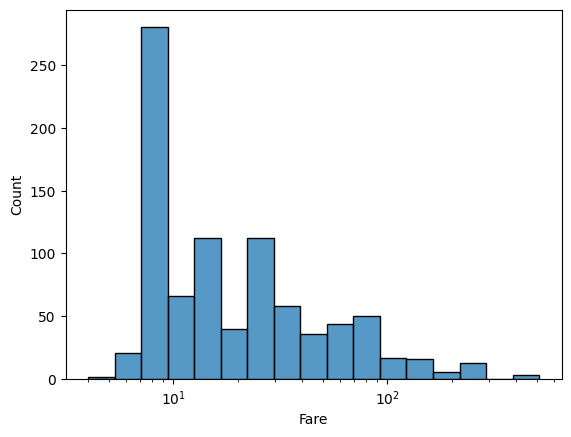

In [53]:
sns.histplot(train["Fare"], log_scale=10)

In [54]:
train[train.Fare < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [55]:
train.Fare.apply(np.log1p).min() #log (x+1)

0.0

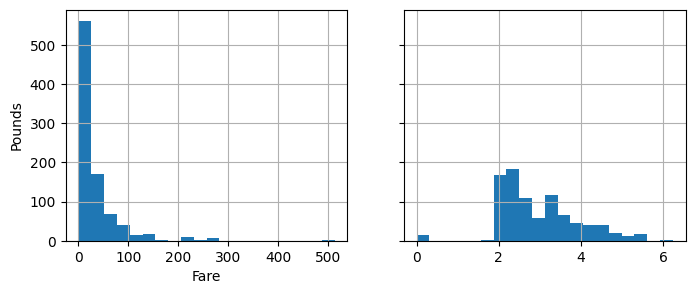

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
train["Fare"].hist(ax=axs[0], bins=20)
train["Fare"].apply(np.log1p).hist(ax=axs[1], bins=20) # Bueno, siempre se aprende algo nuevo log(x+1) -> log1p en numpy
axs[0].set_xlabel("Fare")
#axs[1].set_xlabel("Log of Fare")
axs[0].set_ylabel("Pounds")

plt.show()

In [ ]:
# from sklearn.preprocessing import FunctionTransformer

# log_function = FunctionTransformer(np.log1p)

## Escalado

Dado que utilizaremos un LogisticRegressor, entre otros, vamos a escalar  
Pero sólo con las verdaderas variables numéricas (PClass, SibSp y Parch son realmente ordinales, las dejamos tal cual)  
Si queremos rascar más podemos escalarlas posteriormente y volver a probar.

In [57]:
# Escalado con funciones
from sklearn.preprocessing import StandardScaler

def func_StandardScaler(X, cols_to_scale):
    X_temp = X.copy()
    SScaler = StandardScaler()
    SScaler.fit(X_temp[cols_to_scale])
    X_temp[cols_to_scale] = SScaler.transform(X_temp[cols_to_scale])
    return X_temp

In [58]:
numeric_cols = ["Age","Fare"]

In [59]:
train_processed = func_StandardScaler(train_almost_ready_encoded, numeric_cols)
train_processed

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,-0.565736,1,0,-0.502445,0,1,0,0,1
1,1,1,0.663861,1,0,0.786845,1,0,1,0,0
2,1,3,-0.258337,0,0,-0.488854,1,0,0,0,1
3,1,1,0.433312,1,0,0.420730,1,0,0,0,1
4,0,3,0.433312,0,0,-0.486337,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,-0.181487,0,0,-0.386671,0,1,0,0,1
887,1,1,-0.796286,0,0,-0.044381,1,0,0,0,1
888,0,3,-0.104637,1,2,-0.176263,1,0,0,0,1
889,1,1,-0.258337,0,0,-0.044381,0,1,1,0,0


In [60]:
from sklearn.preprocessing import FunctionTransformer

In [67]:
cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder(drop= "if_binary", handle_unknown= "ignore"))
    ]
)

num_pipeline_log = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("Apply_Logarithm", FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
     ("SScaler", StandardScaler())
    ]
)

num_pipeline = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("SScaler", StandardScaler())
    ]
)

preprocessing = ColumnTransformer(
    [("Process_Numeric_Log", num_pipeline_log, ["Fare"]),
     ("Process_Numeric", num_pipeline, ["Age"]),
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")


In [68]:
pipe_preprocessed = preprocessing.fit_transform(train)
pipe_preprocessed

array([[-0.87974057, -0.56573646,  1.        , ...,  3.        ,
         1.        ,  0.        ],
       [ 1.36121993,  0.66386103,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.79853997, -0.25833709,  0.        , ...,  3.        ,
         0.        ,  0.        ],
       ...,
       [ 0.24200664, -0.1046374 ,  0.        , ...,  3.        ,
         1.        ,  2.        ],
       [ 0.48708246, -0.25833709,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.81898658,  0.20276197,  1.        , ...,  3.        ,
         0.        ,  0.        ]])

In [69]:
preprocessing.get_feature_names_out()

array(['Process_Numeric_Log__Fare', 'Process_Numeric__Age',
       'Process_Categorical__Sex_male', 'Process_Categorical__Embarked_C',
       'Process_Categorical__Embarked_Q',
       'Process_Categorical__Embarked_S', 'remainder__Survived',
       'remainder__Pclass', 'remainder__SibSp', 'remainder__Parch'],
      dtype=object)

In [70]:
df_check = pd.DataFrame(pipe_preprocessed, columns= preprocessing.get_feature_names_out())
df_check

,Process_Numeric_Log__Fare,Process_Numeric__Age,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch
0,-0.879741,-0.565736,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0
1,1.361220,0.663861,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,-0.798540,-0.258337,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
3,1.062038,0.433312,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,-0.784179,0.433312,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,-0.333698,-0.181487,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
887,0.487082,-0.796286,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
888,0.242007,-0.104637,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0
889,0.487082,-0.258337,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Agrupamos funciones para el procesado ...

... e incluimos Survived en las excluidas

In [71]:
columns_to_exclude.append("Survived")

In [72]:
columns_to_exclude

['PassengerId', 'Name', 'Cabin', 'Ticket', 'Survived']

In [73]:
# Preprocesado en una única función, todo junto

def func_exclude_columns(X, exclude_cols = columns_to_exclude):
    # Skip missing values from colum
    X_temp = X[[col for col in X.columns if col not in exclude_cols]].copy()
    return X_temp
    
def func_missing_imputer(X, mean_col_imputed = [], mode_col_imputed = []):
    X_temp = X.copy()
    for col in mean_col_imputed:
        valor_imputado = round(X_temp[col].mean(),0)
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    for col in mode_col_imputed:
        valor_imputado = X_temp[col].mode().values[0]
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    return X_temp
            

def func_oneHotEnconder(X, cols_to_encode):
    X_temp = X.copy()
    OHEncoder = OneHotEncoder()
    OHEncoder.fit(X_temp[cols_to_encode])
    X_temp = pd.concat([X_temp, pd.DataFrame(OHEncoder.transform(X_temp[cols_to_encode]).toarray(),
                                            columns = OHEncoder.get_feature_names_out())], axis = 1)
    return X_temp.drop(cols_to_encode, axis = 1)
    
def func_StandardScaler(X, cols_to_scale):
    X_temp = X.copy()
    SScaler = StandardScaler()
    SScaler.fit(X_temp[cols_to_scale])
    X_temp[cols_to_scale] = SScaler.transform(X_temp[cols_to_scale])
    return X_temp

def preprocess_data(X, 
                    columns_to_exclude = columns_to_exclude, 
                    mean_col_imputed = ["Age"], 
                    mode_col_imputed = ["Embarked"], 
                    cols_to_encode = ["Sex","Embarked","Pclass"], 
                    cols_to_scale = ["Age","Fare"]):
    X_temp = func_exclude_columns(X, columns_to_exclude)
    X_temp = func_missing_imputer(X_temp, mean_col_imputed, mode_col_imputed)
    X_temp = func_oneHotEnconder(X_temp, cols_to_encode)
    X_temp = func_StandardScaler(X_temp, cols_to_scale)

    return X_temp


In [74]:
# Modo Pipeline

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder(drop= "if_binary", handle_unknown= "ignore"))
    ]
)

num_pipeline_log = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("Apply_Logarithm", FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
     ("SScaler", StandardScaler())
    ]
)

num_pipeline = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("SScaler", StandardScaler())
    ]
)

preprocessing = ColumnTransformer(
    [("Process_Numeric_Log", num_pipeline_log, ["Fare"]),
     ("Process_Numeric", num_pipeline, ["Age"]),
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")


In [75]:
func_train = preprocess_data(train)
func_train

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,-0.597055,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.634162,1,0,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.289251,0,0,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.403309,1,0,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.403309,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.212299,0,0,-0.386671,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,-0.827908,0,0,-0.044381,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,0.018554,1,2,-0.176263,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,-0.289251,0,0,-0.044381,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [76]:
pipe_train = preprocessing.fit_transform(train)
pipe_train

array([[-0.87974057, -0.56573646,  1.        , ...,  3.        ,
         1.        ,  0.        ],
       [ 1.36121993,  0.66386103,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.79853997, -0.25833709,  0.        , ...,  3.        ,
         0.        ,  0.        ],
       ...,
       [ 0.24200664, -0.1046374 ,  0.        , ...,  3.        ,
         1.        ,  2.        ],
       [ 0.48708246, -0.25833709,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.81898658,  0.20276197,  1.        , ...,  3.        ,
         0.        ,  0.        ]])

In [77]:
df_pipe_train = pd.DataFrame(pipe_train, columns = preprocessing.get_feature_names_out())
df_pipe_train

,Process_Numeric_Log__Fare,Process_Numeric__Age,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Pclass,remainder__SibSp,remainder__Parch
0,-0.879741,-0.565736,1.0,0.0,0.0,1.0,3.0,1.0,0.0
1,1.361220,0.663861,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.798540,-0.258337,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,1.062038,0.433312,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,-0.784179,0.433312,1.0,0.0,0.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
886,-0.333698,-0.181487,1.0,0.0,0.0,1.0,2.0,0.0,0.0
887,0.487082,-0.796286,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,0.242007,-0.104637,0.0,0.0,0.0,1.0,3.0,1.0,2.0
889,0.487082,-0.258337,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [78]:
func_train.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,-0.597055,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.634162,1,0,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.289251,0,0,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.403309,1,0,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.403309,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [79]:
df_pipe_train.head()

,Process_Numeric_Log__Fare,Process_Numeric__Age,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Pclass,remainder__SibSp,remainder__Parch
0,-0.879741,-0.565736,1.0,0.0,0.0,1.0,3.0,1.0,0.0
1,1.361220,0.663861,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.798540,-0.258337,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,1.062038,0.433312,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,-0.784179,0.433312,1.0,0.0,0.0,1.0,3.0,0.0,0.0


Importante, creamos y_train

In [80]:
y_train = train.Survived

## A MODELAR

Seguiremos comparando el sistema con funciones vs. el sistema con Pipes

Vamos a comparar __LogisticRegression__, __RandomForest__ y __XGBoost__

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

import re


In [82]:
# Usando funciones

model_list = [LogisticRegression, RandomForestClassifier, XGBClassifier]

def model(model_list, X = None, y = None, cv = 5, scoring = "balanced_accuracy"):
    resultados = {}
    X_train = preprocess_data(X)
    
    for model in model_list:
        model_name = re.match("<class '(.*?)'>",str(model)).group(1).split(".")[-1]
        resultados[model_name] = cross_val_score(model(), X_train, y, cv = cv, scoring = scoring)
        print("<%s>: %.4f" %(model_name,np.mean(resultados[model_name])))

    return resultados

In [82]:
model(model_list, train, y_train)

<LogisticRegression>: 0.7740
<RandomForestClassifier>: 0.7891
<XGBClassifier>: 0.8006


{'LogisticRegression': array([0.76416337, 0.77459893, 0.77393048, 0.74064171, 0.81644728]),
 'RandomForestClassifier': array([0.74512516, 0.77740642, 0.83516043, 0.75989305, 0.82781545]),
 'XGBClassifier': array([0.76870883, 0.80120321, 0.83061497, 0.77005348, 0.83240261])}

In [83]:
# Usando Pipes

logistic_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", LogisticRegression())
    ])

random_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", RandomForestClassifier())
    ])

xgb_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", XGBClassifier())
    ])

for name, pipe in zip(["logistic","randomF", "XGB"],[logistic_pipeline, random_pipeline, xgb_pipeline]):
    resultado = cross_val_score(pipe, train, y_train, cv = 5, scoring = "balanced_accuracy")
    print(f"{name}: {np.mean(resultado):.4f}")
    print(resultado)

logistic: 0.7678
[0.77140975 0.76657754 0.76029412 0.74064171 0.80002659]
randomF: 0.7901
[0.77140975 0.77740642 0.82780749 0.75534759 0.81864114]
XGB: 0.8073
[0.79229249 0.80120321 0.84705882 0.76550802 0.83047467]


Los valores en CV son similares, así que vamos a comparar después de ajustar los hiperparámetros

In [84]:
from sklearn.model_selection import GridSearchCV

# Definimos sus hiperparametros
reg_log_param = {
    "penalty": [None,"l2"],
    "C": np.logspace(0, 4, 5),
    "class_weight": ["balanced", None]
    }

rand_forest_param = {
    "n_estimators": [10, 100, 200, 400],
    "max_depth": [1,2,4,8],
    "max_features": [1, 2, 3],
    "class_weight": ["balanced", None]
    }

xgb_param = {
    "n_estimators": [10, 100, 200, 400],
    "max_depth": [1,2,4,8],
    "learning_rate": [0.1,0.2,0.5,1.0],
    "scale_pos_weight": [len(y_train[y_train == 0])/len(y_train[y_train == 1]), 1]
}

cv = 5

gs_reg_log = GridSearchCV(LogisticRegression(),
                          reg_log_param,
                          cv=cv,
                          scoring="balanced_accuracy",
                          verbose=1,
                          n_jobs=-1
                          )

gs_rand_forest = GridSearchCV(RandomForestClassifier(),
                              rand_forest_param,
                              cv=cv,
                              scoring="balanced_accuracy",
                              verbose=1,
                              n_jobs=-1)

gs_xgb = GridSearchCV(XGBClassifier(),
                      xgb_param,
                      cv=cv,
                      scoring="balanced_accuracy",
                      verbose=1,
                      n_jobs=-1)


grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb}


In [85]:
%%time
X_train = preprocess_data(train)

for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: total: 2.88 s
Wall time: 1min 3s


In [86]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
2,gs_xgb,0.821439
1,gs_rand_forest,0.810432
0,gs_reg_log,0.773956


Guardamos el mejor modelo con pickle y con joblib:

In [87]:
best_model = grids[best_grids.iloc[0,0]]
best_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.5, 1.0],
                         'max_depth': [1, 2, 4, 8],
                         'n_estimators': [10, 100, 200, 400],
                         'scale_pos_weight': [1.605263157894737, 1]},
             scoring='balanced_accuracy', verbose=1)

In [88]:
# Usando pickle:
with open('modelo_funciones.pkl', 'wb') as archivo:
    pickle.dump(best_model, archivo)

# Usando joblib:
joblib.dump(best_model, 'modelo_funciones.joblib')

['modelo_funciones.joblib']

Y ahora veamos como sería usando los pipelines:

In [90]:
pipe_reg_log_param = {
    "Modelo__penalty": [None,"l2"],
    "Modelo__C": np.logspace(0, 4, 5),
    "Modelo__class_weight": ["balanced", None]
    }

pipe_rand_forest_param = {
    "Modelo__n_estimators": [10, 100, 200, 400],
    "Modelo__max_depth": [1,2,4,8],
    "Modelo__max_features": [1, 2, 3],
    "Modelo__class_weight": ["balanced", None]
    }

pipe_xgb_param = {
    "Modelo__n_estimators": [10, 100, 200, 400],
    "Modelo__max_depth": [1,2,4,8],
    "Modelo__learning_rate": [0.1,0.2,0.5,1.0],
    "Modelo__scale_pos_weight": [len(y_train[y_train == 0])/len(y_train[y_train == 1]), 1]
    }

cv = 5

gs_reg_log = GridSearchCV(logistic_pipeline,
                          pipe_reg_log_param,
                          cv=cv,
                          scoring="balanced_accuracy",
                          verbose=1,
                          n_jobs=-1)

gs_rand_forest = GridSearchCV(random_pipeline,
                              pipe_rand_forest_param,
                              cv=cv,
                              scoring="balanced_accuracy",
                              verbose=1,
                              n_jobs=-1)

gs_xgb = GridSearchCV(xgb_pipeline,
                      pipe_xgb_param,
                      cv=cv,
                      scoring="balanced_accuracy",
                      verbose=1,
                      n_jobs=-1)


pipe_grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb}


In [91]:
%%time

for nombre, grid_search in pipe_grids.items():
    grid_search.fit(train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: total: 5.92 s
Wall time: 58.5 s


c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [92]:
best_grids = [(i, j.best_score_) for i, j in pipe_grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
2,gs_xgb,0.818292
1,gs_rand_forest,0.816674
0,gs_reg_log,0.772235


Grabamos el mejor modelo con y sin pipeline:

In [94]:
best_model = pipe_grids[best_grids.iloc[0,0]]
best_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Process_Numeric_Log',
                                                                         Pipeline(steps=[('Impute_Median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('Apply_Logarithm',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['Fare']),
                                                                        ('Process_N...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Modelo__learning_rate': [0.1, 0.2, 0.5, 1.0],
                         'Modelo__max_depth': [1, 2, 4, 8],
                         'Modelo__n_estimators': [10, 100, 200, 400],
                         'Modelo__scale_pos_weight': [1.605263157894737, 1]},
             scoring='balanced_accuracy', verbose=1)

In [96]:
# Usando pickle:
with open('modelo_pipeline.pkl', 'wb') as archivo: # wb = write binary
    pickle.dump(best_model, archivo)

# Usando joblib:
joblib.dump(best_model, 'modelo_pipeline.joblib')

['modelo_pipeline.joblib']

#### **¡Enhorabuena! Por fin podemos pasar al cuaderno Pipelines_II**

###### 